# Undestanding the opioid crisis with a modified epidemic model
----

In [83]:
import numpy as np
import pandas as pd
import scipy as sp
import time
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Import data

In [84]:
data = pd.read_csv('NCHS_-_Drug_Poisoning_Mortality_by_State__United_States (1).csv')
data.columns = [u'Year', u'Sex', u'Age', u'Race', u'State', 
                u'Deaths', u'Population', u'Crude Death Rate', 
                u'Standard Error for Crude Rate', u'Low Confidence Limit for Crude Rate', 
                u'Upper Confidence Limit for Crude Rate', u'Age-adjusted Rate', 
                u'Standard Error Age-adjusted Rate', 
                u'Lower Confidence Limit for Age-adjusted rate', 
                u'Upper Confidence Limit for Age-adjusted Rate', 
                u'State Crude Rate in Range', u'US Crude Rate', 
                u'US Age-adjusted Rate']

data = data.query('Age== "All Ages" & Sex=="Both Sexes" & Race=="All Races-All Origins" & State!="United States"')

data['Deaths'] = data['Deaths'].apply(lambda x: x.replace(',',''))
data['Deaths'] = pd.to_numeric(data['Deaths'], errors='coerce')
data['Population'] = data['Population'].apply(lambda x: x.replace(',',''))
data['Population'] = pd.to_numeric(data['Population'], errors='coerce')
data['Age-adjusted Rate'] = data['Age-adjusted Rate']*data['Population']/100000

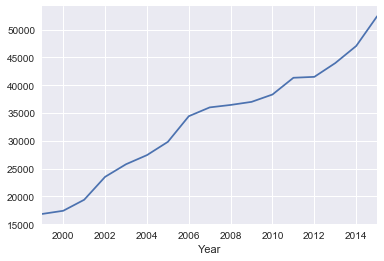

In [85]:
yearly_deaths = data.groupby(['Year'])['Deaths'].sum()
yearly_deaths.plot()

In [86]:
def opioid_ours(state, t, alpha, beta_1, beta_2, gamma, zeta, delta, sigma, mu, mu_star):
    
    '''epsilon was defined to be the prescribed to susceptible rate, but has the
    constraint that it is equal to 1 - gamma.
    
    delta is defined to be the rate of recovery, and is assumed to be 1 - sigma - nu*A
    '''
    S, P, A, R = state
    nu = (1 - sigma - delta - mu)/A
    S_prime = -alpha*S - beta_1*S*A - beta_2*S*P + (1-gamma)*P + delta*R + mu*(P+R) + mu_star*A
    P_prime = alpha*S - (1 + mu)*P
    A_prime = gamma*P + sigma*R + beta_1*S*A + beta_2*S*P + nu*R*A - (zeta + mu_star)*A
    R_prime = zeta*A - nu*R*A - (delta + sigma + mu)*R
    return [S_prime, P_prime, A_prime, R_prime]

In [87]:
def opioid_deaths3(t, P, A, R, alpha, beta_1, beta_2, zeta, gamma, mu_star):
    
    S = 1.0 - (P + A + R)
    state0 = [S, P, A, R] #S P A R
    
    numerical_sol = sp.integrate.odeint(opioid_ours, state0, t,
                                        args=(alpha, beta_1, beta_2, gamma, zeta, delta, sigma, mu, mu_star))

    opioid_deaths = numerical_sol[:,2] * (mu_star - mu)
    
    return opioid_deaths

In [88]:
# parameters
epsilon = 0.74 # Prescribed to Susceptible rate
gamma = 0.26 # rate of addiction among prescribed users
gamma = 0.08
sigma = 0.7 # natural relapse rate of R 
mu = 0.00824 # death rate
mu_star = 0.023 #0.0235275 what I think it should be
delta = 0.6 # R to S rate. 0.1 is default
beta_1 = 0.0625 # total addiction rate for Susceptible due to illegal access
beta_2 = 0.0625 # total addiction rate for Susceptible due to illegal access
alpha = 0.3 # prescription rate. could be 0-1
zeta = 0.7 # rate of A entry into rehab. could be 0-1

In [89]:
fitted_params, _ = sp.optimize.curve_fit(opioid_deaths3, t, yearly_deaths.values/(320.0 * 10**6),
                                         method="trf",
                                         bounds=(
                                         (0, 0, 0, 0, 0, 0, 0, 0, 0),
                                         (0.50, 0.2, 0.2, 1, 1, 1, 1, 1, 1)
                                         )
                                        )
fitted_params

array([  3.07194683e-03,   4.07392127e-03,   3.13547230e-04,
         5.28031117e-02,   3.24357986e-01,   1.52443333e-02,
         7.73271214e-01,   3.10689282e-02,   2.12326042e-02])

In [90]:
P, A, R, alpha, beta_1, beta_2, zeta, gamma, mu_star = fitted_params

In [92]:
t = np.linspace(0,17,17)
state0 = [1 - (P + A + R), P, A, R]

numerical_sol = sp.integrate.odeint(opioid_ours, state0, t,
                                    args=(alpha, beta_1, beta_2, gamma, zeta, delta, sigma, mu, mu_star))

S = numerical_sol[:,0]
P = numerical_sol[:,1]
A = numerical_sol[:,2]
R = numerical_sol[:,3]

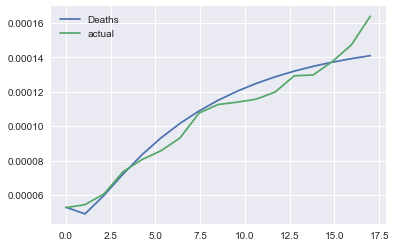

In [93]:
plt.plot(t, (mu_star-mu)*A, label="Deaths")
plt.plot(t, yearly_deaths.values /320000000., label = "actual")
plt.legend()

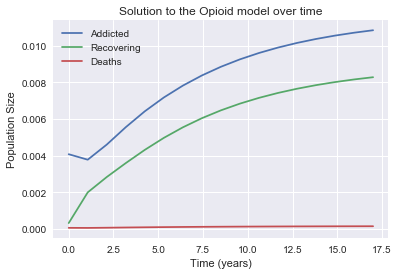

In [94]:
#plt.plot(t, S, label="Susceptible")
#plt.plot(t, P, label= "Prescribed")
plt.plot(t, A, label= "Addicted")
plt.plot(t, R, label= "Recovering")
plt.plot(t, (mu_star-mu)*A, label="Deaths")
plt.title("Solution to the Opioid model over time")
plt.xlabel("Time (years)")
plt.ylabel("Population Size")
plt.legend()

